In [ ]:
!pip install pystan
!pip install fbprophet

    100% |################################| 55.1MB 15kB/s  eta 0:00:01 0% |                                | 327kB 5.7MB/s eta 0:00:10    7% |##                              | 4.2MB 10.9MB/s eta 0:00:05    8% |##                              | 4.7MB 11.0MB/s eta 0:00:05    13% |####                            | 7.4MB 18.6MB/s eta 0:00:03    50% |################                | 27.6MB 5.6MB/s eta 0:00:05    86% |###########################     | 47.6MB 18.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for fbprophet ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/e7/62/5b/94bb082348b1e1f45d3ab97a33982c5aaaefa7f2fecc1d3c89
Successfully built fbprophet


In [2]:
from fbprophet import Prophet,diagnostics
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
%matplotlib inline
week_offset = timedelta(days=7)
pysqldf = lambda q: sqldf(q, globals())

In [4]:
df = pd.read_excel('./datasource.xlsx')

In [5]:
phone = pysqldf("select 日期,sum(数量) 数量 from df where 渠道 = '电话' group by 日期  order by 1")
phone.columns = ['ds','y']
phone.ds = pd.to_datetime(phone.ds)

In [338]:
holidays = pd.read_excel('./holidays.xlsx')
holidays.ds = pd.to_datetime(holidays.ds)
holidays = holidays.loc[(holidays.ds>=phone.ds.min())&(holidays['是否与上一节日重叠']==0)]
fit_holiday = holidays[['holiday','ds','lower_window','upper_window']].copy()

In [388]:
phone_train = phone.loc[phone.ds.between('2015-11-01','2017-12-30')].copy()

In [389]:
m = Prophet(changepoint_prior_scale=0.002,holidays_prior_scale=10,seasonality_prior_scale=10, 
            holidays=fit_holiday,weekly_seasonality=True) 

m.add_seasonality(name='yearly', period=365.25, fourier_order=10,prior_scale=10)  
m.add_seasonality(name='weekly', period=7     , fourier_order=5,prior_scale=10)

In [391]:
m.fit(phone_train) 
future = m.make_future_dataframe(70) 

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [393]:
forecast = m.predict(df=future) 
print('fitted') 

fitted


In [394]:
df = pd.merge(phone,forecast.loc[:,['ds','yhat_lower','yhat_upper','holidays','yearly','weekly','trend','yhat']],on='ds',how='right') 
df = df.set_index('ds',drop=0) 
df['err_ratio'] = df['yhat'] / df['y'] - 1 
df['type'] = df.ds.apply(lambda i : 'train' if i<= m.history_dates.max() else 'predict')
df['ds'] = df['ds'].apply(lambda i : i.strftime('%F'))
df['weekday'] = pd.to_datetime(df.ds).apply(lambda i : i.weekday() )+1

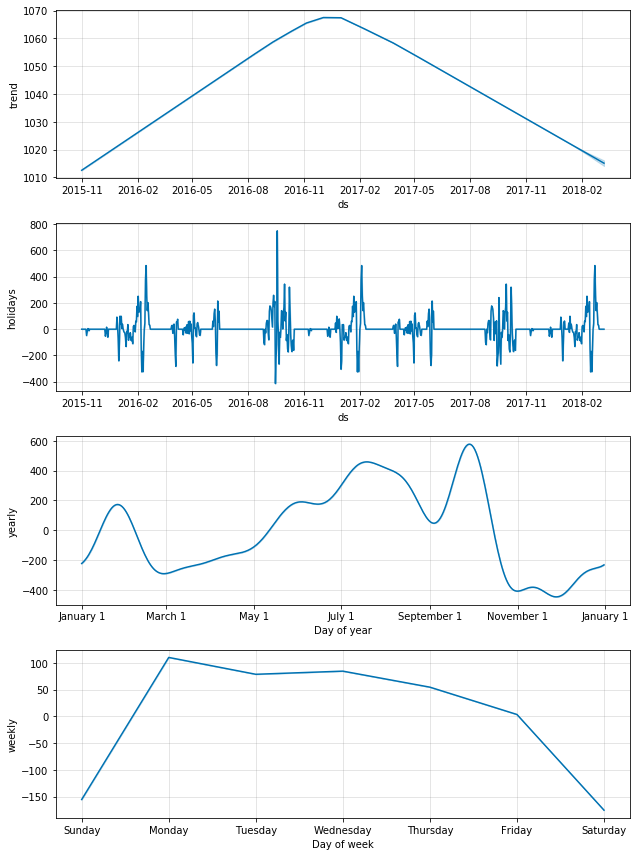

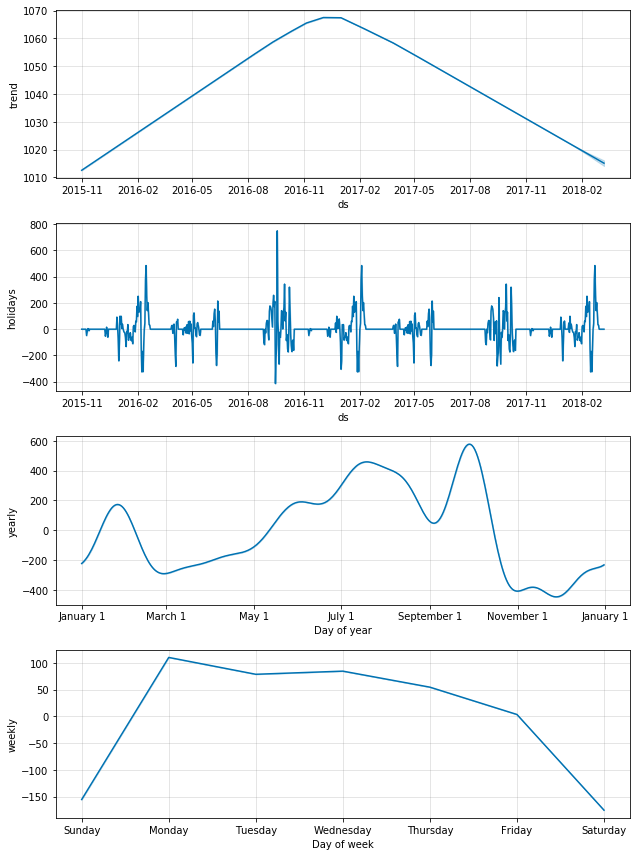

In [395]:
m.plot_components(forecast)

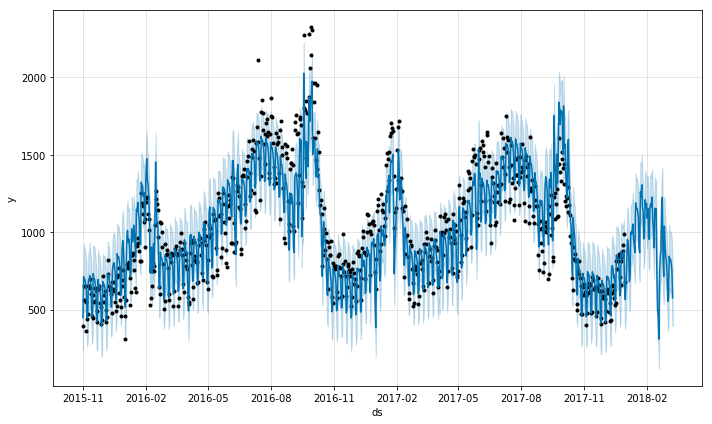

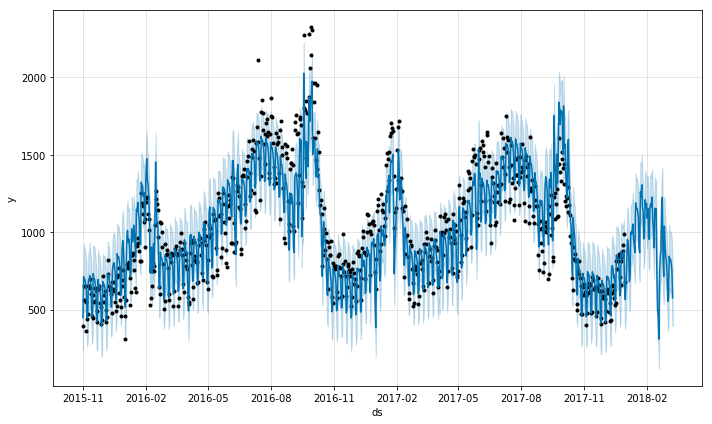

In [396]:
m.plot(forecast)

In [397]:
df.loc[df.ds.between('2017-12-10','2018-01-03')]

,ds,y,yhat_lower,yhat_upper,holidays,yearly,weekly,trend,yhat,err_ratio,type,weekday
ds,,,,,,,,,,,,
2017-12-10,2017-12-10,432.0,263.117744,649.276501,-53.702527,-358.163390,-155.360679,1026.344028,459.117433,0.062772,train,7
2017-12-11,2017-12-11,604.0,563.522354,950.185879,-29.374118,-346.774324,109.953606,1026.219232,760.024396,0.258319,train,1
2017-12-12,2017-12-12,649.0,595.404058,978.541600,15.299301,-335.651536,78.489260,1026.094437,784.231461,0.208369,train,2
2017-12-13,2017-12-13,658.0,577.287688,954.316190,-17.774083,-324.969814,84.357769,1025.969641,767.583513,0.166540,train,3
2017-12-14,2017-12-14,576.0,508.108869,893.926225,-61.235468,-314.882612,54.441341,1025.844845,704.168107,0.222514,train,4
2017-12-15,2017-12-15,629.0,526.455733,920.301829,0.000000,-305.517331,3.421257,1025.720049,723.623975,0.150436,train,5
2017-12-16,2017-12-16,528.0,349.788661,741.884922,0.000000,-296.971375,-175.302554,1025.595253,553.321323,0.047957,train,6
2017-12-17,2017-12-17,543.0,394.003167,749.011107,0.000000,-289.309084,-155.360679,1025.470457,580.800694,0.069615,train,7
2017-12-18,2017-12-18,811.0,662.335062,1037.561620,0.000000,-282.559627,109.953606,1025.345661,852.739639,0.051467,train,1


In [398]:
df.to_excel('forecast_phone.xlsx',index=0)